# Predicting the Percentage of Telecom Call drops with AI

Problem Statement:

    In the telecom domain, a call drop is a situation where a call on a wireless network is disconnected before the caller ends the call. These call drops can happen for several reasons. Inadequate coverage such as lack of tower infrastructure, network traffic, number of calls at a given tower, time of call, weather status can greatly affect the stability of the network. Sometimes, the network capacity is simply not being ramped up at the same pace as usage, which results in overloaded networks.

Objective:

    We must understand the reasons for the call drops along with the contributing factors that influence the call drops for the selected tower.

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the dataset
df = pd.read_excel('tower_weather_dataset.xlsx',sheet_name = 2)
df.head()

,key,site_id,day,Total Calls,Traffic,lat,long,Call Dropped,Bucket,day_key,Hour_bucket,weather,drop_percentage
0,1717|20170101|1,1717,2017-01-01,499,Low,40.710567,-74.007338,16,1,20170101,00:00 to 4:00,Smoke,3
1,1717|20170101|2,1717,2017-01-01,554,Medium,40.710567,-74.007338,44,2,20170101,4:00 to 8:00,Shallow Fog,8
2,1717|20170101|3,1717,2017-01-01,301,Low,40.710567,-74.007338,17,3,20170101,8:00 to 12:00,Shallow Fog,6
3,1717|20170101|4,1717,2017-01-01,514,Low,40.710567,-74.007338,16,4,20170101,12:00 to 16:00,Fog,3
4,1717|20170101|5,1717,2017-01-01,262,Low,40.710567,-74.007338,14,5,20170101,16:00 to 20:00,Fog,5


In [3]:
df.shape

(906, 13)

In [4]:
df.isna().sum()

key                0
site_id            0
day                0
Total Calls        0
Traffic            0
lat                0
long               0
Call Dropped       0
Bucket             0
day_key            0
Hour_bucket        0
weather            0
drop_percentage    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              906 non-null    object        
 1   site_id          906 non-null    int64         
 2   day              906 non-null    datetime64[ns]
 3   Total Calls      906 non-null    int64         
 4   Traffic          906 non-null    object        
 5   lat              906 non-null    float64       
 6   long             906 non-null    float64       
 7   Call Dropped     906 non-null    int64         
 8   Bucket           906 non-null    int64         
 9   day_key          906 non-null    int64         
 10  Hour_bucket      906 non-null    object        
 11  weather          906 non-null    object        
 12  drop_percentage  906 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 77.9+ KB


### Feature Engineering

<AxesSubplot:>

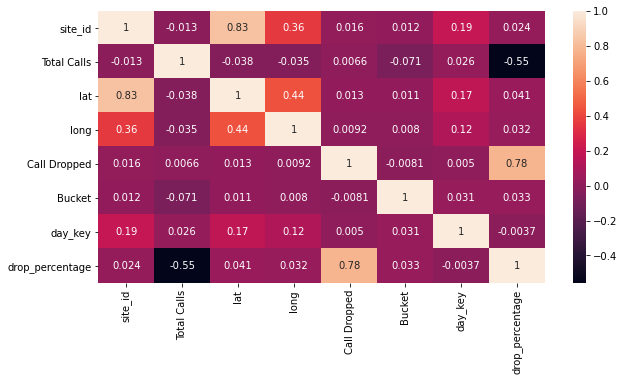

In [7]:
from matplotlib.pyplot import figure
figure(figsize = (10,5))
sns.heatmap(df.corr(),annot = True)

From the above figure you can notice that Lat and Site_id are highly correlated so we will remove Site_id,
Call Dropped feature is used in deriving the drop_percentage column so it should also be removed,
Lat, Long, Day_key, Bucket column are anyway doesnt contribute much to target variable so they have to be removed.

In [8]:
df.drop(columns = ['key','site_id','day','lat','long','Bucket','day_key','Hour_bucket'],inplace = True)

In [9]:
df.head(3)

,Total Calls,Traffic,Call Dropped,weather,drop_percentage
0,499,Low,16,Smoke,3
1,554,Medium,44,Shallow Fog,8
2,301,Low,17,Shallow Fog,6


Note:
    There are some categorical values which can be encoded as numbers, so we will take a look at unique values present as categories and convert these fields as category and encode them

In [10]:
Traffic_n = pd.get_dummies(df['Traffic'],drop_first = 'True')
# Weather_n = pd.get_dummies(df['weather'],drop_first = 'True')

In [11]:
df = pd.concat([df,Traffic_n],axis = 1)
df.head(3)

,Total Calls,Traffic,Call Dropped,weather,drop_percentage,Low,Medium
0,499,Low,16,Smoke,3,1,0
1,554,Medium,44,Shallow Fog,8,0,1
2,301,Low,17,Shallow Fog,6,1,0


Now we have new dataframes by one-hot encoding, so we will concat them with our existing dataframe, but before that we will remove category fields as we don't need them right!

In [12]:
df.drop(columns = ['Traffic','Call Dropped'],inplace = True)

In [13]:
df.head(3)

,Total Calls,weather,drop_percentage,Low,Medium
0,499,Smoke,3,1,0
1,554,Shallow Fog,8,0,1
2,301,Shallow Fog,6,1,0


Dimensionality Reduction using PCA

##### Apply PCA only on Weather data

In [14]:
Weather_n = pd.get_dummies(df['weather'],drop_first = 'True')

In [15]:
Weather_n.columns.size

13

Note:
    There are 13 weather type features and now will apply Pca and reduce the number of features to 5

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 4)

In [17]:
pca.fit(Weather_n)

PCA(n_components=4)

In [18]:
pca_weather = pca.transform(Weather_n)

In [19]:
weather_after_pca = pd.DataFrame(pca_weather,columns = ['weather1','weather2','weather3','weather4'])

In [20]:
df.shape

(906, 5)

In [21]:
weather_after_pca.shape

(906, 4)

In [22]:
df = pd.concat([df,weather_after_pca],axis = 1)
df.head(3)

,Total Calls,weather,drop_percentage,Low,Medium,weather1,weather2,weather3,weather4
0,499,Smoke,3,1,0,-0.204023,0.836698,-0.159533,-0.049212
1,554,Shallow Fog,8,0,1,-0.639384,-0.508263,-0.121249,-0.040534
2,301,Shallow Fog,6,1,0,-0.639384,-0.508263,-0.121249,-0.040534


In [23]:
df.drop(columns = ['weather'],inplace = True)

In [24]:
df.head(3)

,Total Calls,drop_percentage,Low,Medium,weather1,weather2,weather3,weather4
0,499,3,1,0,-0.204023,0.836698,-0.159533,-0.049212
1,554,8,0,1,-0.639384,-0.508263,-0.121249,-0.040534
2,301,6,1,0,-0.639384,-0.508263,-0.121249,-0.040534


## Model Development

In [25]:
x = df.drop(columns = ['drop_percentage'])
y = df[['drop_percentage']]

It is recommended practice of splitting data in training and testing before using it in model, in our case we are keeping 80/20 data for training and testing respectively

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 0)

## Model-1 AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
adaboost = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(criterion = 'mse',ccp_alpha= 0.1))
adaboost.fit(x_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.1))

In [28]:
y_pred1 = adaboost.predict(x_test)

#### Model Score, Feature Importance, Cross Validation Score

In [29]:
from sklearn.metrics import r2_score
print('Model Score on Test data is: {}'.format(r2_score(y_test,y_pred1)))

Model Score on Test data is: 0.883470820120968


In [30]:
print('Model Score on Train data is: {}'.format(adaboost.score(x_train,y_train)))

Model Score on Train data is: 0.9082734395620174


In [31]:
adaboost.feature_importances_

array([0.62169725, 0.22424595, 0.11846905, 0.00805079, 0.01043559,
       0.00513946, 0.01196191])

In [32]:
from sklearn.model_selection import cross_val_score,KFold
kfold = KFold(n_splits=5)
cross_validation = cross_val_score(adaboost, x, y, cv=kfold)
print('Cross Validation Score: {}'.format(cross_validation.mean()))

Cross Validation Score: 0.866953459968026


## Model-2 Gradient Boost

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(criterion='mse',learning_rate = 0.1)
gb.fit(x_train,y_train)

GradientBoostingRegressor(criterion='mse')

In [34]:
y_pred2 = gb.predict(x_test)

#### Model Score, Feature Importance, Cross Validation Score

In [35]:
from sklearn.metrics import r2_score
print('Model Score on Test data is: {}'.format(r2_score(y_test,y_pred2)))

Model Score on Test data is: 0.8819583746307706


In [36]:
print('Model Score on Train data is: {}'.format(gb.score(x_train,y_train)))

Model Score on Train data is: 0.912001725870232


In [37]:
gb.feature_importances_

array([0.41875747, 0.39419268, 0.18058255, 0.00133939, 0.00178694,
       0.0011411 , 0.00219987])

In [38]:
from sklearn.model_selection import cross_val_score,KFold
kfold = KFold(n_splits=5)
cross_validation = cross_val_score(gb, x, y, cv=kfold)
print('Cross Validation Score: {}'.format(cross_validation.mean()))

Cross Validation Score: 0.857150928392844


## Standard Scaling

Here we'll normalize our data by using sklearn's StandardScaler

In [39]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

## Model-3 KNN Regressor

In [40]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7,algorithm='kd_tree')
knn.fit(x_train_scaled,y_train)

KNeighborsRegressor(algorithm='kd_tree', n_neighbors=7)

In [41]:
y_pred3 = knn.predict(x_test_scaled)

#### Model Score, Prediction vs Actual, Cross Validation Score

In [42]:
from sklearn.metrics import r2_score
print('Model Score on Test data is: {}'.format(r2_score(y_test,y_pred3)))

Model Score on Test data is: 0.8552987220137496


In [43]:
y_test.head().values

array([[13],
       [ 5],
       [13],
       [ 4],
       [ 4]], dtype=int64)

In [44]:
y_pred3[:5]

array([[12.28571429],
       [ 7.71428571],
       [15.85714286],
       [ 4.        ],
       [ 5.85714286]])

In [45]:
from sklearn.model_selection import cross_val_score,KFold
kfold = KFold(n_splits=5)
cross_validation = cross_val_score(knn, x_train_scaled, y_train, cv=kfold)
print('Cross Validation Score: {}'.format(cross_validation.mean()))

Cross Validation Score: 0.8410426130593212


## Model-4 SVM Regressor

In [46]:
from sklearn.svm import SVR
svm = SVR(kernel = 'rbf',C = 2)
svm.fit(x_train_scaled,y_train)

SVR(C=2)

In [47]:
y_pred4 = svm.predict(x_test_scaled)

#### Model Score, Prediction vs Actual, Cross Validation Score

In [48]:
from sklearn.metrics import r2_score
print('Model Score on Test data is: {}'.format(r2_score(y_test,y_pred4)))

Model Score on Test data is: 0.8571021461980086


In [49]:
from sklearn.model_selection import cross_val_score,KFold
kfold = KFold(n_splits=5)
cross_validation = cross_val_score(svm, x_train_scaled, y_train, cv=kfold)
print('Cross Validation Score: {}'.format(cross_validation.mean()))

Cross Validation Score: 0.8410328018628157


In [50]:
y_test.head().values

array([[13],
       [ 5],
       [13],
       [ 4],
       [ 4]], dtype=int64)

In [51]:
y_pred4[:5]

array([13.06967148,  6.73649231, 14.98899574,  4.07668079,  6.51721379])

Conclusion:

    ADA-Boost and Gradient-Boost consistently crush the rest of the competition. However, as there is a small margin, 
    the winning models are both AdaBoost and GradientBoost. The Adaboost,GradientBoost manages to achieve very high accuracy of 88% and on Cross validation the accuracy was 86 %.
    SVM and KNN achieves slightly lower than this, with 85% accuracy and on cross validation 84%.